In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

### Importando Datos

In [2]:
data_train = pd.read_csv('Data/train_set.csv')
data_test = pd.read_csv('Data/test_set.csv')

/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_42311/4187072533.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv('Data/train_set.csv')
/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_42311/4187072533.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_test = pd.read_csv('Data/test_set.csv')


In [3]:
data_train.shape

(700000, 14)

In [4]:
data_train.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'bike_id', 'plan_duration',
       'trip_route_category', 'passholder_type', 'start_station',
       'end_station'],
      dtype='object')

In [5]:
data_test.shape

(569886, 12)

In [6]:
data_test.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category',
       'start_station', 'end_station'],
      dtype='object')

### Limpiando datos

In [7]:
data_train.isna().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5563
start_lon               5563
end_lat                18574
end_lon                18574
bike_id                    0
plan_duration            208
trip_route_category        0
passholder_type         2576
start_station              0
end_station                0
dtype: int64

In [8]:
data_test.isna().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               4622
start_lon               4622
end_lat                14891
end_lon                14891
bike_id                    0
trip_route_category        0
start_station              0
end_station                0
dtype: int64

### Transformar las columas fecha

In [9]:
def parse_dates(date):
    try:
        return pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        try:
            return pd.to_datetime(date, format='%m/%d/%Y %H:%M')
        except ValueError:
            return pd.NaT

In [10]:
data_train['start_time'] = data_train['start_time'].apply(parse_dates)
data_train['end_time'] = data_train['end_time'].apply(parse_dates)
data_test['start_time'] = data_test['start_time'].apply(parse_dates)
data_test['end_time'] = data_test['end_time'].apply(parse_dates)

### Limpiando el dataset

In [11]:
data_train_cleaned = data_train.copy()
data_test_cleaned = data_test.copy()

In [12]:
geo_columns = ['start_lat', 'start_lon', 'end_lat', 'end_lon']

In [13]:
for col in geo_columns:
    if 'start' in col:
        data_train_cleaned[col] = data_train_cleaned.groupby('start_station')[col].transform(lambda x: x.fillna(x.median()))
        data_test_cleaned[col] = data_test_cleaned.groupby('start_station')[col].transform(lambda x: x.fillna(x.median()))
    else:
        data_train_cleaned[col] = data_train_cleaned.groupby('end_station')[col].transform(lambda x: x.fillna(x.median()))
        data_test_cleaned[col] = data_test_cleaned.groupby('end_station')[col].transform(lambda x: x.fillna(x.median()))

In [14]:
for col in geo_columns:
    data_train_cleaned[col].fillna(data_train_cleaned[col].median(), inplace=True)
    data_test_cleaned[col].fillna(data_test_cleaned[col].median(), inplace=True)


/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_42311/1047874757.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train_cleaned[col].fillna(data_train_cleaned[col].median(), inplace=True)
/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_42311/1047874757.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [15]:
data_train_cleaned.isna().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_lat                 0
start_lon                 0
end_lat                   0
end_lon                   0
bike_id                   0
plan_duration           208
trip_route_category       0
passholder_type        2576
start_station             0
end_station               0
dtype: int64

In [16]:
data_test_cleaned.isna().sum()

trip_id                0
duration               0
start_time             0
end_time               0
start_lat              0
start_lon              0
end_lat                0
end_lon                0
bike_id                0
trip_route_category    0
start_station          0
end_station            0
dtype: int64

In [17]:
data_train_cleaned['duration'].describe()

count    700000.000000
mean         37.084979
std         125.302510
min           1.000000
25%           7.000000
50%          13.000000
75%          26.000000
max        1440.000000
Name: duration, dtype: float64

In [18]:
data_train_cleaned = data_train_cleaned.dropna(subset=['passholder_type'])

### Haciendo feature engineering

In [19]:
def feature_engineering(df):
    
    df['trip_duration_calculated'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
    df['is_weekend'] = df['start_time'].dt.weekday >= 5
    
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0  # Radio de la Tierra en kilómetros
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c
    
    df['distance'] = haversine(
        df['start_lat'], df['start_lon'], df['end_lat'], df['end_lon']
    )

    df['start_hour'] = df['start_time'].dt.hour
    bins = [0, 6, 12, 18, 24]
    labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    df['time_slot'] = pd.cut(df['start_hour'], bins=bins, labels=labels, right=False)

    df['day_of_week'] = df['start_time'].dt.day_name()


    return df

In [20]:
data_train_cleaned = feature_engineering(data_train_cleaned)
data_test_cleaned = feature_engineering(data_test_cleaned)

In [21]:
data_train_cleaned.dtypes

trip_id                              int64
duration                             int64
start_time                  datetime64[ns]
end_time                    datetime64[ns]
start_lat                          float64
start_lon                          float64
end_lat                            float64
end_lon                            float64
bike_id                             object
plan_duration                      float64
trip_route_category                 object
passholder_type                     object
start_station                        int64
end_station                          int64
trip_duration_calculated           float64
is_weekend                            bool
distance                           float64
start_hour                           int32
time_slot                         category
day_of_week                         object
dtype: object

### Revisar datos sesgados o outliers

In [22]:
def handle_outliers(df):
     # Filtrar por límites IQR para trip_duration_calculated
    q1_duration = df['trip_duration_calculated'].quantile(0.25)
    q3_duration = df['trip_duration_calculated'].quantile(0.75)
    iqr_duration = q3_duration - q1_duration
    lower_bound_duration = q1_duration - 2 * iqr_duration
    upper_bound_duration = q3_duration + 2 * iqr_duration
    
    # Filtrar por límites IQR para distance
    q1_distance = df['distance'].quantile(0.25)
    q3_distance = df['distance'].quantile(0.75)
    iqr_distance = q3_distance - q1_distance
    lower_bound_distance = q1_distance - 2 * iqr_distance
    upper_bound_distance = q3_distance + 2 * iqr_distance

    # Aplicar filtros
    df = df[
        (df['trip_duration_calculated'] >= lower_bound_duration) & 
        (df['trip_duration_calculated'] <= upper_bound_duration) & 
        (df['distance'] >= lower_bound_distance) & 
        (df['distance'] <= upper_bound_distance)
    ]
    return df

In [23]:
data_train_cleaned = handle_outliers(data_train_cleaned)

In [24]:
data_train_cleaned.shape

(614884, 20)

In [25]:
data_train_cleaned.isna().sum()

trip_id                       0
duration                      0
start_time                    0
end_time                      0
start_lat                     0
start_lon                     0
end_lat                       0
end_lon                       0
bike_id                       0
plan_duration               175
trip_route_category           0
passholder_type               0
start_station                 0
end_station                   0
trip_duration_calculated      0
is_weekend                    0
distance                      0
start_hour                    0
time_slot                     0
day_of_week                   0
dtype: int64

In [26]:
data_train_cleaned['passholder_type'].value_counts()

passholder_type
Monthly Pass    378671
Walk-up         164302
Annual Pass      32080
One Day Pass     28568
Flex Pass        11208
Testing             55
Name: count, dtype: int64

### Modelo multiclass

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, RFECV

In [28]:
le = LabelEncoder()
data_train_cleaned['passholder_type_encoded'] = le.fit_transform(data_train_cleaned['passholder_type'])

In [29]:
encoder = OneHotEncoder()
encoded_days_train = encoder.fit_transform(data_train_cleaned[['day_of_week', 'time_slot']]).toarray()
encoded_days_test = encoder.transform(data_test_cleaned[['day_of_week', 'time_slot']]).toarray()

In [30]:
from sklearn.preprocessing import LabelEncoder
le_trip_route = LabelEncoder()
data_train_cleaned['trip_route_category_encoded'] = le_trip_route.fit_transform(data_train_cleaned['trip_route_category'])
data_test_cleaned['trip_route_category_encoded'] = le_trip_route.transform(data_test_cleaned['trip_route_category'])

In [31]:
encoded_columns = encoder.get_feature_names_out(['day_of_week', 'time_slot'])
data_train_cleaned = pd.concat([data_train_cleaned, pd.DataFrame(encoded_days_train, columns=encoded_columns, index=data_train_cleaned.index)], axis=1)
data_test_cleaned = pd.concat([data_test_cleaned, pd.DataFrame(encoded_days_test, columns=encoded_columns, index=data_test_cleaned.index)], axis=1)

In [32]:
features = ['trip_duration_calculated', 'start_hour', 'distance', 'is_weekend'] + list(encoded_columns) + ['trip_route_category_encoded']

In [33]:
X_train = data_train_cleaned[features]
y_train = data_train_cleaned['passholder_type_encoded']
X_test = data_test_cleaned[features]

In [34]:
#from sklearn.feature_selection import SelectFromModel, RFECV

In [35]:
# def select_features_with_rf(X, y):
#     model = RandomForestClassifier(random_state=42)
#     model.fit(X, y)
#     selector = SelectFromModel(model, prefit=True, threshold='mean')  # Selecciona características por encima del promedio
#     selected_features = X.columns[selector.get_support()]
#     print(f"Características seleccionadas: {selected_features.tolist()}")
#     return X[selected_features], selected_features

In [36]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [37]:
# 6. Selección de características parsimoniosas
model_temp = RandomForestClassifier(random_state=42)
model_temp.fit(X_train_smote, y_train_smote)
selector = SelectFromModel(model_temp, prefit=True, threshold="mean")
selected_features = X_train.columns[selector.get_support()]
X_train_smote_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)

/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [38]:
print(f"Características seleccionadas: {selected_features.tolist()}")

Características seleccionadas: ['trip_duration_calculated', 'distance']


### Random Forest

In [39]:
#model = RandomForestClassifier(random_state=42)
model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
#model.fit(X_train_smote, y_train_smote)

In [40]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=kf, scoring='accuracy')
# print(f"Accuracy promedio en Cross-Validation: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

#model.fit(X_train_smote, y_train_smote)

# X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# )

# model.fit(X_train_split, y_train_split)
# y_pred_split = model.predict(X_val_split)

In [41]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_smote_selected, y_train_smote, cv=kf, scoring='accuracy')
print(f"Accuracy promedio en Cross-Validation: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Entrenar modelo final
model.fit(X_train_smote_selected, y_train_smote)

# 8. Validación interna
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
X_val_split_selected = selector.transform(X_val_split)
y_val_pred = model.predict(X_val_split_selected)

Accuracy promedio en Cross-Validation: 0.4708 ± 0.0008


/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [42]:
print("Accuracy en validación interna:", accuracy_score(y_val_split, y_val_pred))
print("Classification Report:\n", classification_report(y_val_split, y_val_pred, target_names=le.classes_))

Accuracy en validación interna: 0.21344641680964732
Classification Report:
               precision    recall  f1-score   support

 Annual Pass       0.12      0.43      0.18      6416
   Flex Pass       0.03      0.55      0.06      2242
Monthly Pass       0.83      0.12      0.22     75734
One Day Pass       0.09      0.45      0.15      5714
     Testing       0.00      0.82      0.00        11
     Walk-up       0.61      0.31      0.42     32860

    accuracy                           0.21    122977
   macro avg       0.28      0.45      0.17    122977
weighted avg       0.69      0.21      0.26    122977



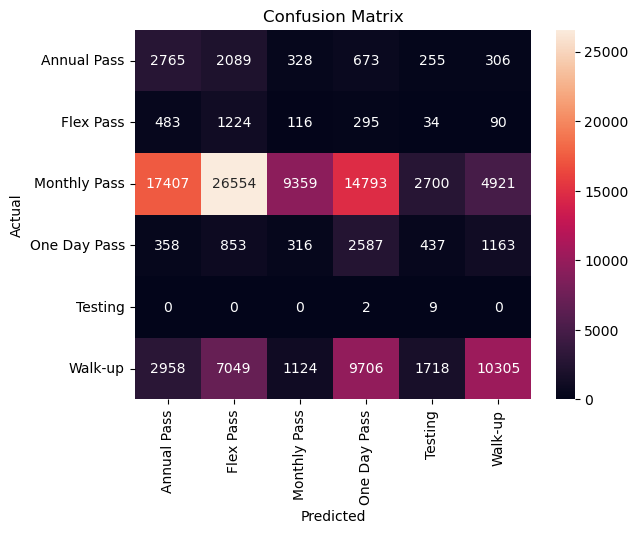

In [43]:
conf_matrix = confusion_matrix(y_val_split, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
y_test_pred = model.predict(X_test_selected)
data_test_cleaned['predicted_passholder_type'] = le.inverse_transform(y_test_pred)

In [45]:
print(data_test_cleaned[['trip_id', 'predicted_passholder_type']].head())

    trip_id predicted_passholder_type
0  17059130                   Walk-up
1  17059129              One Day Pass
2  17059126              One Day Pass
3  17059125                 Flex Pass
4  17061379                   Walk-up


In [46]:
data_test_cleaned['predicted_passholder_type'].value_counts()

predicted_passholder_type
Flex Pass       153725
One Day Pass    136791
Walk-up         109228
Annual Pass      99449
Monthly Pass     49030
Testing          21663
Name: count, dtype: int64

In [47]:
# Extraer importancia de características del modelo
importances = model.feature_importances_

# Crear un DataFrame para ordenar y mostrar
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las principales características
print("Importancia de características:")
print(feature_importance_df)

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de Características')
plt.gca().invert_yaxis()  # Invertir para mostrar la más importante arriba
plt.show()

ValueError: All arrays must be of the same length

In [47]:
# def select_features(X, y):
#     #Modelo base para selección de características
#     model = RandomForestClassifier(random_state=42)
#     model.fit(X, y)
    
#     #Seleccionar características con importancia promedio
#     selector = SelectFromModel(model, prefit=True, threshold="mean")
#     selected_features = X.columns[selector.get_support()]
#     X_selected = selector.transform(X)
    
#     print(f"Características seleccionadas: {list(selected_features)}")
#     return X_selected, selected_features

In [48]:
#X_train_smote_selected, selected_features = select_features(X_train_smote, y_train_smote)

In [49]:
#selected_features

In [50]:
#data_train_cleaned['trip_route_category'].value_counts()

In [51]:
#data_test_cleaned['trip_route_category'].value_counts()